#### Algorithm 1

In [25]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import tensorly as tl
import math 
from matplotlib import pyplot
import keras
from keras.datasets import mnist

sns.set_theme()

In [4]:
def multiplication(T, M, mode): 
    
    descriptor = list(T.shape)
    descriptor[mode] = M.shape[0]
    pom = tl.unfold(T, mode)
    
    return (tl.fold( M @ pom, mode, descriptor))  

In [5]:
def HOSVD(T):

    U1, _, _ = np.linalg.svd(tl.unfold(T, 0), full_matrices=False) 
    U2, _, _ = np.linalg.svd(tl.unfold(T, 1), full_matrices=False) 
    U3, _, _ = np.linalg.svd(tl.unfold(T, 2), full_matrices=False)

    S = tl.tenalg.multi_mode_dot(T, [np.transpose(U1),np.transpose(U2),np.transpose(U3)], modes = [0,1,2], transpose=False)
    
    return(S, U1, U2)

In [30]:
def alg1_train(A_train, D_train,  k):
    
    tensor = [None] * k
    
    for i in range(k):

        T = tl.vec_to_tensor(A_train[:, np.where(D_train == i)[1]], (int(math.sqrt(A_train.shape[0])),int(math.sqrt(A_train.shape[0])),A_train[:, np.where(D_train == i)[1]].shape[1]))
        S, U1, U2 = HOSVD(T)
    
        tensor[i] = np.zeros((int(math.sqrt(A_train.shape[0])),int(math.sqrt(A_train.shape[0])), S.shape[2]))

        for j in range(S.shape[2]):
            
            pom_1 = multiplication(tl.vec_to_tensor(S[:,:,j], (int(math.sqrt(A_train.shape[0])),int(math.sqrt(A_train.shape[0])),1)), U1, 0)
            pom_2 = multiplication(pom_1, U2, 1)
            
            tensor[i][:, :, j] = np.reshape(pom_2 / np.linalg.norm(pom_2), (int(math.sqrt(A_train.shape[0])),int(math.sqrt(A_train.shape[0]))))
            
    return(tensor)

In [31]:
def alg1_test(A_test, tensor,  k, l):
        
    digits = []

    for i in range(A_test.shape[1]): 
        
        D = np.reshape((A_test[:, i] / np.linalg.norm(A_test[:, i])), (int(math.sqrt(A_train.shape[0])),int(math.sqrt(A_train.shape[0]))))
        max_R = np.NINF
        digit = 0 
    
        for j in range(k):
            
            R = 0
            
            for z in range(l): 
                R += np.trace(np.matmul(np.transpose(D), tensor[j][:,:,z])) ** 2  
                
            if( R > max_R): 
                max_R = R
                digit = j
            
        digits.append(digit)
        
    return digits

#### Application of the algorithm for the MNIST digits

In [32]:
##reading data
mat = scipy.io.loadmat('azip.mat')
A_train = mat['azip'] 
mat = scipy.io.loadmat('dzip.mat')
D_train = mat['dzip'] 

mat = scipy.io.loadmat('atest.mat')
A_test = mat['testzip'] 
mat = scipy.io.loadmat('dtest.mat')
D_test = mat['dtest'] 

k = np.unique(D_train).size
l = 30

In [33]:
tensor = alg1_train(A_train, D_train, k )

predictions = alg1_test(A_test, tensor, k, l)

np.count_nonzero(predictions == D_test[0]) / len(D_test[0])

0.9342301943198804

In [35]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_y = np.transpose(np.reshape(train_y, (60000,1)))
test_y = np.transpose(np.reshape(test_y, (10000,1)))

print('X_train: ' + str(train_X.shape))
#print('Y_train: ' + str(train_y.shape))
#print('X_test:  '  + str(test_X.shape))
#print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)


In [36]:
#nova = np.reshape(train_X[0],(28*28, 1))
#print(nova.shape)
#image = np.reshape(nova, (28,28))
#pyplot.imshow(image,cmap='gray')
#pyplot.show()


A_train = np.empty([train_X.shape[1] ** 2, train_X.shape[0]])

for i in range(train_X.shape[0]):
    A_train[:,i] = np.reshape(train_X[i],(28*28,)) 
    
D_train = train_y

A_test = np.empty([test_X.shape[1] ** 2, test_X.shape[0]])

for i in range(test_X.shape[0]):
    A_test[:,i] = np.reshape(test_X[i],(test_X.shape[1]**2,))
    
D_test = test_y

k = np.unique(D_train).size

l = 30 


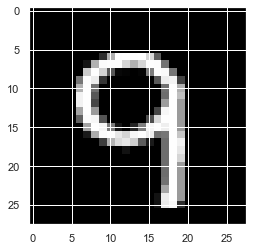

In [26]:

image = np.reshape(A_train[:,56788], (28,28))
pyplot.imshow(image,cmap='gray')
pyplot.show()

In [38]:
tensor = alg1_train(A_train, D_train, k )

predictions = alg1_test(A_test, tensor, k, l)

np.count_nonzero(predictions == D_test[0]) / len(D_test[0])